# MNIST with Virtual Branching

In [1]:
import tensorflow as tf
import numpy as np
import os
from scipy.special import softmax
import matplotlib.pyplot as plt
import time
from sklearn.manifold import TSNE

In [2]:
import vbranch as vb

In [3]:
save = True
model_id = 1
architecture = 'cnn'

## Load Data

In [4]:
dataset = 'mnist'
num_classes = 10
num_features = 784
samples_per_class = 200
(X_train, y_train), (X_test, y_test) = vb.utils.get_data(dataset, architecture, num_classes,
                                                         num_features, samples_per_class)

In [5]:
x_shape = (None,) + X_train.shape[1:]
y_shape = (None, num_classes)

## Train

### Build Model

In [6]:
BATCH_SIZE = 32
EPOCHS = 30
STEPS_PER_EPOCH = 100
NUM_BRANCHES = 4
SHARED_FRAC = 1
model_path = os.path.join('models', 'vb-{}-{}-B{:d}-S{:.2f}_{:d}'.format(dataset, architecture,
    NUM_BRANCHES, SHARED_FRAC, model_id))

In [7]:
model_path

'models/vb-mnist-cnn-B4-S1.00_1'

In [8]:
tf.reset_default_graph()

x = tf.placeholder('float32', x_shape, name='x')
y = tf.placeholder('float32', y_shape, name='y')

batch_size = tf.placeholder('int64', name='batch_size')

iterators = [None] * NUM_BRANCHES
inputs = [None] * NUM_BRANCHES
labels_one_hot = [None] * NUM_BRANCHES

for i in range(NUM_BRANCHES):
    dataset = tf.data.Dataset.from_tensor_slices((x,y)).\
        repeat().batch(batch_size).shuffle(buffer_size=4*BATCH_SIZE)

    iterators[i] = dataset.make_initializable_iterator()
    inputs[i], labels_one_hot[i] = iterators[i].get_next('input')

In [9]:
def build_model(architecture,inputs,labels, num_classes,num_branches,model_id,
        shared_frac, test=False):
        
    if architecture == 'fcn':
        model = vb.vbranch_simple_fcn(inputs,
            ([128]*num_branches, int(128*shared_frac)),
            ([num_classes]*num_branches, int(num_classes*shared_frac)),
            branches=num_branches, name='model_' + str(model_id))
    elif architecture == 'cnn':
        model = vb.vbranch_simple_cnn(inputs, (num_classes, 0),
            ([16]*num_branches, int(16*shared_frac)),
            ([32]*num_branches, int(32*shared_frac)),
            branches=num_branches, name='model_' + str(model_id))
    else:
        raise ValueError('invalid model')

    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    model.compile(optimizer, 'softmax_cross_entropy_with_logits',
                    labels_one_hot=labels, test=test)
#     if not test:
    model.summary()

    return model

In [10]:
model = build_model(architecture, inputs, labels_one_hot, num_classes,
        NUM_BRANCHES, model_id, SHARED_FRAC)

i   Layer name         Output shape         Num param  Inbound            
--------------------------------------------------------------------------
    Input              [None,28,28,1]                                     
--------------------------------------------------------------------------
    Input              [None,28,28,1]                                     
--------------------------------------------------------------------------
    Input              [None,28,28,1]                                     
--------------------------------------------------------------------------
    Input              [None,28,28,1]                                     
--------------------------------------------------------------------------
0   conv2d_1_1         [None,26,26,16] []   160        input              
                       [None,26,26,16] []                                 
                       [None,26,26,16] []                                 
                       [N

In [11]:
# Build copy of model for testing
x_place = tf.placeholder('float32', x_shape, name='x_test')
y_place = tf.placeholder('float32', y_shape, name='y_test')
test_model = build_model(architecture, x_place, [y_place]*NUM_BRANCHES, num_classes,
    NUM_BRANCHES, model_id, SHARED_FRAC, test=True)

i   Layer name         Output shape         Num param  Inbound            
--------------------------------------------------------------------------
    Input              [None,28,28,1]                                     
--------------------------------------------------------------------------
    Input              [None,28,28,1]                                     
--------------------------------------------------------------------------
    Input              [None,28,28,1]                                     
--------------------------------------------------------------------------
    Input              [None,28,28,1]                                     
--------------------------------------------------------------------------
0   conv2d_1_1         [None,26,26,16] []   160        input              
                       [None,26,26,16] []                                 
                       [None,26,26,16] []                                 
                       [N

### Run Ops

In [12]:
history = model.fit(iterators, X_train, y_train, EPOCHS, STEPS_PER_EPOCH,
        BATCH_SIZE, validation=(X_test, y_test), test_model=test_model,
        save_model_path=model_path)

Epoch 1/30
 - 4s - train_acc_4: 0.5216 - train_loss_4: 1.5953 - train_acc_1: 0.5284 - train_loss_3: 1.4531 - train_loss_1: 1.5292 - train_acc_3: 0.5666 - train_acc_ensemble: 0.2597 - train_loss_2: 1.4955 - train_acc_2: 0.5587 - val_loss_2: 0.7330 - val_loss_1: 0.7069 - val_acc_4: 0.8851 - val_loss_3: 0.6337 - val_acc_ensemble: 0.9164 - val_loss_4: 0.7274 - val_acc_2: 0.8832 - val_acc_1: 0.8951 - val_acc_3: 0.9000
Epoch 2/30
 - 1s - train_acc_4: 0.9175 - train_loss_4: 0.4733 - train_acc_1: 0.9113 - train_loss_3: 0.4173 - train_loss_1: 0.4691 - train_acc_3: 0.9269 - train_acc_ensemble: 0.3325 - train_loss_2: 0.4623 - train_acc_2: 0.9209 - val_loss_2: 0.2439 - val_loss_1: 0.2403 - val_acc_4: 0.9537 - val_loss_3: 0.2313 - val_acc_ensemble: 0.9606 - val_loss_4: 0.2635 - val_acc_2: 0.9558 - val_acc_1: 0.9572 - val_acc_3: 0.9568
Epoch 3/30
 - 2s - train_acc_4: 0.9619 - train_loss_4: 0.2086 - train_acc_1: 0.9591 - train_loss_3: 0.1971 - train_loss_1: 0.2095 - train_acc_3: 0.9609 - train_acc_en

Epoch 21/30
 - 1s - train_acc_4: 1.0000 - train_loss_4: 0.0021 - train_acc_1: 1.0000 - train_loss_3: 0.0020 - train_loss_1: 0.0019 - train_acc_3: 1.0000 - train_acc_ensemble: 0.3856 - train_loss_2: 0.0020 - train_acc_2: 1.0000 - val_loss_2: 0.0701 - val_loss_1: 0.0684 - val_acc_4: 0.9793 - val_loss_3: 0.0691 - val_acc_ensemble: 0.9799 - val_loss_4: 0.0691 - val_acc_2: 0.9789 - val_acc_1: 0.9795 - val_acc_3: 0.9794
Epoch 22/30
 - 1s - train_acc_4: 1.0000 - train_loss_4: 0.0018 - train_acc_1: 1.0000 - train_loss_3: 0.0017 - train_loss_1: 0.0017 - train_acc_3: 1.0000 - train_acc_ensemble: 0.3853 - train_loss_2: 0.0018 - train_acc_2: 1.0000 - val_loss_2: 0.0683 - val_loss_1: 0.0666 - val_acc_4: 0.9793 - val_loss_3: 0.0673 - val_acc_ensemble: 0.9802 - val_loss_4: 0.0677 - val_acc_2: 0.9800 - val_acc_1: 0.9803 - val_acc_3: 0.9793
Epoch 23/30
 - 1s - train_acc_4: 1.0000 - train_loss_4: 0.0016 - train_acc_1: 1.0000 - train_loss_3: 0.0014 - train_loss_1: 0.0016 - train_acc_3: 1.0000 - train_acc

## Load Model

In [15]:
# test_init_ops = ['test_init_op_'+str(i+1) for i in range(NUM_BRANCHES)]
# losses = ['loss_'+str(i+1)+':0' for i in range(NUM_BRANCHES)]
# train_acc_ops = ['train_acc_'+str(i+1)+':0' for i in range(NUM_BRANCHES)]

# inputs = ['input_{}:0'.format(i+1) for i in range(NUM_BRANCHES)]
# labels_one_hot = ['input_{}:1'.format(i+1) for i in range(NUM_BRANCHES)]
outputs = ['model_{}_1/output_vb{}:0'.format(model_id, i+1) for i in range(NUM_BRANCHES)]

In [16]:
with tf.Session() as sess:
    model_path = os.path.join('models', 'vb-mnist-{}-B{:d}-S{:.2f}_{:d}'.format(architecture,
        NUM_BRANCHES, SHARED_FRAC, model_id))
    meta_path = os.path.join(model_path, 'ckpt.meta')
    ckpt = tf.train.get_checkpoint_state(model_path)

    imported_graph = tf.train.import_meta_graph(meta_path)
    imported_graph.restore(sess, ckpt.model_checkpoint_path)

#     sess.run(test_init_ops, feed_dict={'batch_size:0': len(X_test)})
    features = sess.run(outputs, feed_dict={'x_test:0':X_test})
    
#     sample_size = 250
#     sess.run(test_init_ops, feed_dict={'batch_size:0':sample_size})
#     X_test_samples, y_test_samples, features = sess.run([inputs, labels_one_hot, outputs])

INFO:tensorflow:Restoring parameters from models/vb-mnist-cnn-B4-S1.00_1/ckpt


In [17]:
# print('Loss:', np.mean(val_losses))
# print('Acc:', val_acc)
# print('Indiv accs:', indiv_accs)

## Feature Visualization

In [ ]:
mean_features = np.mean(features, axis=0)
print(mean_features.shape)

In [ ]:
start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(mean_features)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-start))

In [ ]:
labels = np.argmax(y_test_samples[0], axis=-1)

In [13]:
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=labels, cmap=plt.cm.jet)
plt.colorbar()
plt.show()

NameError: name 'tsne_results' is not defined

## Feature Correlation

In [18]:
features = np.array(features)
corr_list = []

for i in range(features.shape[1]):
    corr = np.corrcoef(features[:, i], rowvar=False)
    corr_list.append(corr)

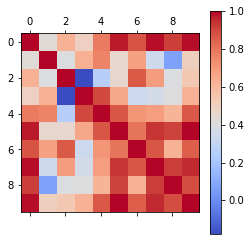

In [24]:
plt.matshow(corr_list[4], cmap=plt.cm.coolwarm)
plt.colorbar()
plt.show()

In [25]:
corr_list = np.array(corr_list)
mean_corr = np.mean(np.sum(np.square(corr_list), axis=(1,2)) - 10)
print(mean_corr)

37.69674353424667


In [ ]:
0: 30.46930946455603
0.75: 30.68270134409282